# Assignment 2 (Image Mosaicing)
- Aman Joshi(2018201097)

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

## Find Homography
Homography is calculated using DLT. Two images are related by a homographic matrix. The points in one image are directly related to point in other image.
<br>
The homography can be found using DLT

In [3]:
def find_homography(image_points_1, image_points_2):
    size = len(image_points_1) * 2
    A = np.empty(shape=(size, 9))
    count = 0
    for point1, point2 in zip(image_points_1,
                                       image_points_2):
        x = point1[0]
        y = point1[1]
        u = point2[0]
        v = point2[1]
        A[count] = np.array([0, 0, 0, -x, -y, -1, v*x, v*y, v])
        A[count + 1] = np.array([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        count += 2
        
    S, v, d = np.linalg.svd(A)
    H = d[-1,:] / d[-1,-1]
    H = np.reshape(H, (3,3))
#     print(H)
    return H

## Find Features
- I have used Sift to find the features of the image.
- For Matching between the two images I have used Brute force KNN matcher to get the matching points
- To get the idea of matching I have drawn lines between the corresponding matches

In [4]:
def get_features(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    sift = cv.xfeatures2d.SIFT_create()
    kps, descs = sift.detectAndCompute(gray, None)
    return kps, descs


def find_matches(image1, image2, factor=.2):
    kp1, des1 = get_features(image1)
    kp2, des2 = get_features(image2)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < factor * n.distance:
            good.append([m])
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None, flags=2)
    plt.imshow(img3)
    plt.show()
    if len(good) >= 4:
        src = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1, 2)
        dst = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1, 2)
    else:
        print("errrrrr")
        return
    x = False
    if src.mean() < dst.mean():
        src, dst = dst, src
        x=True
    H = find_homography(dst, src)
    return H,x

## Stiching two images:
- For stiching two images find homography between two images.
- To find the left image I have calculated mean of the matched points and thus decided which image will be on left and which will be on the right.
- Then convert the right image to left image using homography matrix.
- Stich the converted image and left image.

In [5]:
def stich_two_images(image1, image2, factor=.2):
#     print(image1.shape, image2.shape)
    homography,x  = find_matches(image1, image2, factor)
    if x is True:
        print("swap")
        image1, image2 = image2, image1
    dst = cv.warpPerspective(image2,homography,(image1.shape[1] + image2.shape[1],image1.shape[0] + image2.shape[0]))
    orig_dst = dst
    dst[:image1.shape[0], :image1.shape[1]] = image1
    r = dst[:,:, 0 ]/1
    g = dst[:,:, 1 ]/1
    b = dst[:,:, 2 ]/1
    alpha = r+g+b
    pixel_preserve = (alpha<=5)
    for i in range (image1.shape[0]):
        for j in range(image1.shape[1]):
            if pixel_preserve[i][j]:
                dst[i][j] = orig_dst[i][j]
    temp = np.sum(dst, axis=2)
    dst = dst[~np.all(temp == 0, axis=1)]
    dst = dst[:,~np.all(temp == 0, axis=0)]
    return dst

## Stiching function:
- The images are stiched one by one
- While doing for multiple images there were black regions on some places.
- To resolve it I have changed the black pixels from the right image.
- The technique used is similar to what we have done in Chroma Keying

In [6]:
def stich(images, factor=.2):
    right = images[0]
    images = images[1:]
    for image in images:
        right = stich_two_images(image, right, factor)
        plt.imshow(right)
        plt.show()
    cv.imwrite("stichediamge.png", right)
    return right

2

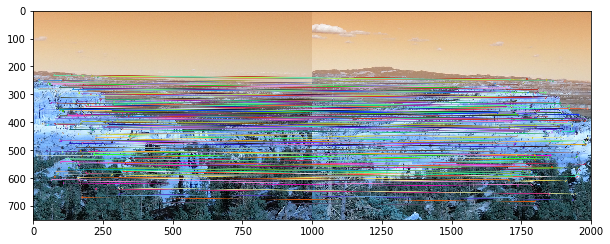

swap


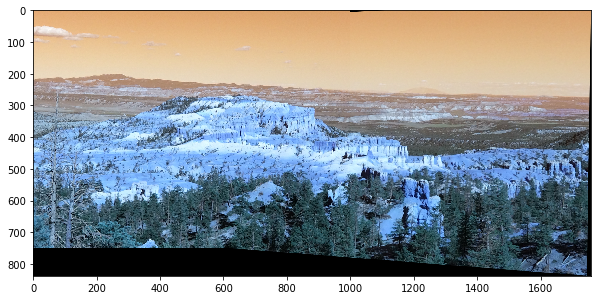

True

In [7]:
images1_source = ['test_images/img1_1.png', 'test_images/img1_2.png']
images1 = [cv.imread(i) for i in images1_source]
display(len(images1))
stiched_image = stich(images1)
cv.imwrite("landscape.jpg", stiched_image)

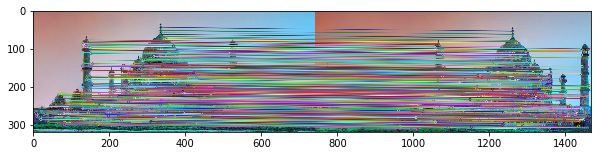

swap


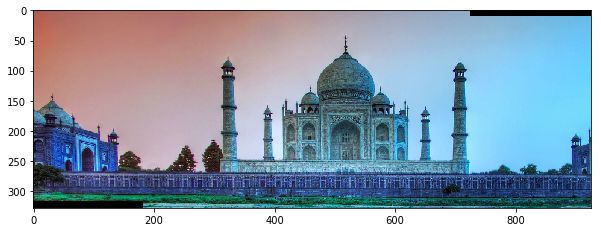

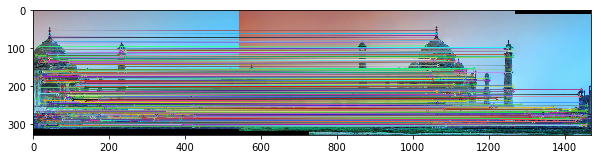

swap


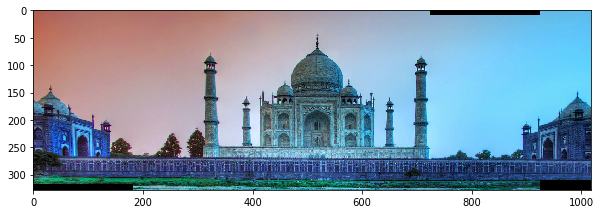

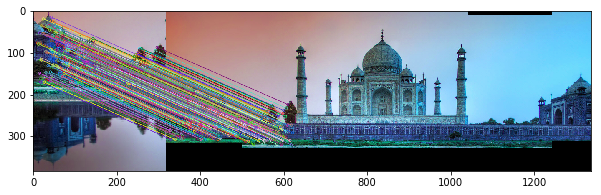

swap


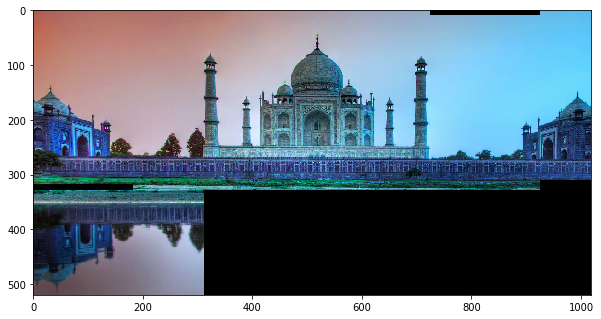

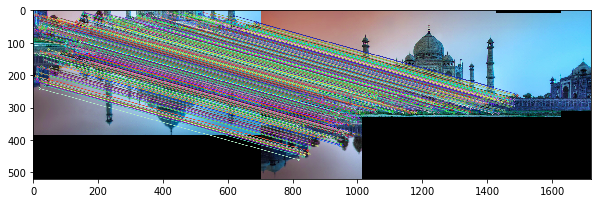

swap


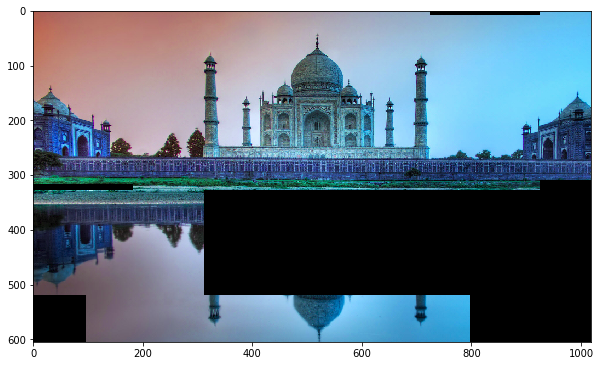

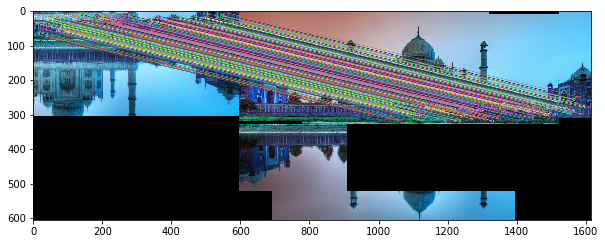

swap


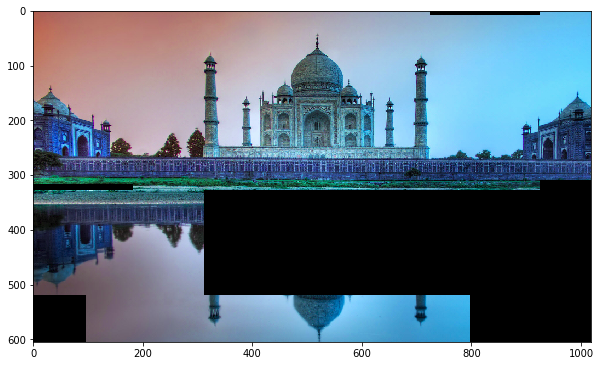

True

In [8]:
images2_source = ['test_images/img2_1.png', 'test_images/img2_2.png',
                 'test_images/img2_3.png', 'test_images/img2_4.png', 
                 'test_images/img2_5.png', 'test_images/img2_6.png']
images2 = [cv.imread(i) for i in images2_source]
# display(len(images2))
striched_image = stich(images2)
cv.imwrite("taj.jpg", striched_image)

2

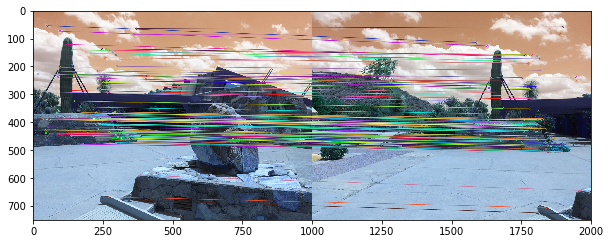

swap


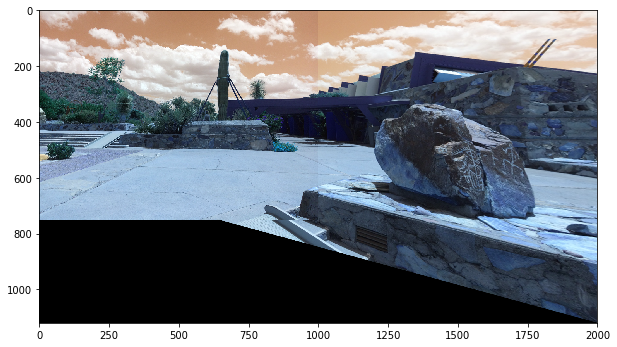

True

In [9]:
images3_source = ['test_images/img3_1.png', 'test_images/img3_2.png']
images3 = [cv.imread(i) for i in images3_source]
display(len(images3))
stiched_image = stich(images3, factor=.4)
cv.imwrite("ques.jpg", stiched_image)

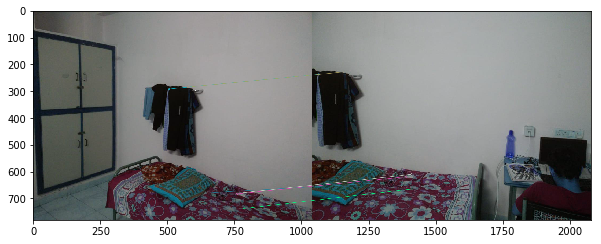

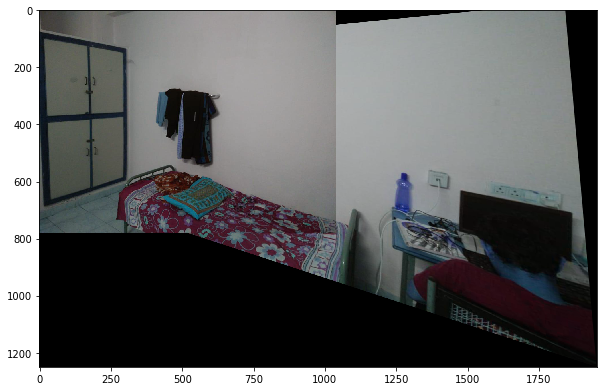

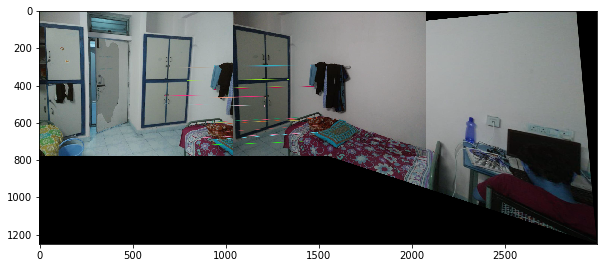

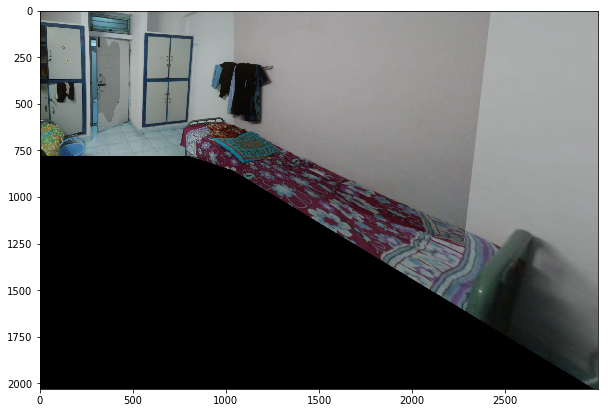

In [10]:
image_my = ['my_images/I0.jpg','my_images/I1.jpg', 'my_images/I2.jpg']
images_my = [cv.imread(i) for i in image_my]
stiched_image = stich(images_my, factor=.3)

## Challanges:
- Stiching multiple images
- Stiching images irrespective of orders.
- Removing the Black portion from the converted images.

# Learning:
- Homography matrix calculation
- Stiching Images
- Learned cv functions